# Isotropic vortex

In this notebook, we will model an isotropic vortex as a solution to Euler equations in 2D using Clawpack. The model is example 2.2 from paper ["On the Order of Accuracy and Numerical Performance of Two Classes of Finite Volume WENO Schemes" by Zhang et al](https://www-cambridge-org.colorado.idm.oclc.org/core/journals/communications-in-computational-physics/article/abs/on-the-order-of-accuracy-and-numerical-performance-of-two-classes-of-finite-volume-weno-schemes/30DE290D74891895A66456B940DF2A5E). The code is based on the previous notebook for PyClaw
[Quadrants by David Ketcheson](https://github.com/clawpack/apps/blob/master/notebooks/pyclaw/Quadrants.ipynb).

## Set-up 

The general Euler equation for compressible flow has the following form:
$u_t+f(u)_x+g(u)_y=0$ 
with
$$u=
\begin{bmatrix}
\rho\\ \rho v\\ \rho w\\ E
\end{bmatrix},\quad
f(u)=\begin{bmatrix}
\rho v\\ \rho v^2+P\\ \rho vw\\ v(E+P)
\end{bmatrix},\quad
g(u)=\begin{bmatrix}
\rho w\\ \rho vw\\ \rho w^2+P\\ w(E+P)
\end{bmatrix},
$$

where $\rho$ is the density, $v$, $w$ are the velocities, $E$ is the total energy and $P$ is the pressure. The boundary conditions are periodic. The following code sets up generic Euler problem.

In [22]:
#loading necessary packages
from clawpack import pyclaw
from clawpack import riemann
import matplotlib.pyplot as plt
import numpy as np

#set the controller
clawSC = pyclaw.Controller()
clawSC.tfinal = 10.#final time, chosen that we can observe full period with velocity (1,1)
clawSC.num_output_times =100#time step

#specify that we use riemann solver for Euler system of 4
riemann_solver = riemann.euler_4wave_2D
clawSC.solver = pyclaw.SharpClawSolver2D(riemann_solver)
clawSC.solver.all_bcs = pyclaw.BC.periodic#fixed,this problem uses periodic BC

grid_size = (50,50)#spatial grid
domain = pyclaw.Domain( (0.,0.), (10.,10.), grid_size)#fixed domain size

## Vortex evolution

Let $\epsilon$ be the vortex strength, $T=P/\rho$ be the temperature, and $S=P/\rho^\gamma$ be the enthalpy ($\gamma$ is the common gas constant fixed at $1.4$). The vortex will be initially positioned at the center $(5,5)$. Radius $r$ is then $\sqrt{(x-5)^2+(y-5)^2}$. The mean flow values are $\rho=1,\,P=1,\,v=1,\,w=1$. The vortex evolution can be modeled by introducing perturbations to $v,\,w,\,T,\,S$ (denoted by $\delta$).

$$
\begin{bmatrix}
\delta v\\ \delta w\\ \delta T\\ \delta S
\end{bmatrix}=
\begin{bmatrix}
-\frac{\epsilon}{2\pi}e^{0.5(1-r^2)}(y-5)^2\\
\frac{\epsilon}{2\pi}e^{0.5(1-r^2)}(x-5)^2\\
-\frac{(\gamma-1)\epsilon^2}{8\gamma\pi^2}e^{1-r^2}\\
0
\end{bmatrix}.
$$

Note however that the initial conditions need to be specified for conservative quantities (i.e. entries of $u$). Here we refer to a work done for [the vortex example done for libCEED](https://github.com/CEED/libCEED/blob/main/examples/fluids/qfunctions/eulervortex.h#L92-L107). Using the mean flow values, we get that $T=1+\delta T$ and $S_0=1$.  By the formulae for $T$ and $S$ we get $\rho=(T/S)^{\gamma-1}$. The initial conditions are as follows:
$$
\begin{bmatrix}
\rho\\
\rho(1+\delta v)\\
\rho(1+\delta w)\\
0.5\rho((1+\delta v)^2+(1+\delta w)^2)+\frac{\rho T}{\gamma-1}
\end{bmatrix}.
$$

The code below sets up the initial conditions and SharpClaw (via PyClaw) is used to solve this Euler problem.

In [23]:
#here we find the solution and set the parameters
clawSC.solution = pyclaw.Solution(clawSC.solver.num_eqn,domain)
gam = 1.4
clawSC.solution.problem_data['gamma']  = gam

# Set initial data
q = clawSC.solution.q
xx,yy = domain.grid.p_centers
eps=5 #vortex strength
xbar=xx-5.0
ybar=yy-5.0
r2=xbar**2+ybar**2#radius
A=eps/(2*np.pi)*np.exp(0.5*(1.0-r2))#velocity perturbation
dT=-(gam-1.)*eps**2/(8*gam*np.pi**2)*np.exp(1-r2)#temperature perturbation
S_vor=1#initial enthalpy, no perturbation
T=1+dT#initial temperature + perturbation
rho  = pow(T / S_vor, 1 / (gam - 1.));#initial density
P=rho*T#initial pressure
c_v=1#mean velocity in x
c_w=1#mean velocity in y
#conservative quantities go here
q[0,...] =rho
q[1,...] = rho*(c_v-A*ybar)
q[2,...] = rho*(c_w+A*xbar)
q[3,...] = 0.5*rho*((c_v-A*ybar)**2+(c_w+A*xbar)**2) + P/(gam-1.)

clawSC.keep_copy = True       # Keep solution data in memory for plotting
clawSC.output_format = None   # Don't write solution data to file
clawSC.solver.dt_initial=1.e99
status = clawSC.run()

2023-12-11 14:16:56,659 INFO CLAW: Solution 0 computed for time t=0.000000
2023-12-11 14:16:56,679 INFO CLAW: Solution 1 computed for time t=0.100000
2023-12-11 14:16:56,696 INFO CLAW: Solution 2 computed for time t=0.200000
2023-12-11 14:16:56,713 INFO CLAW: Solution 3 computed for time t=0.300000
2023-12-11 14:16:56,727 INFO CLAW: Solution 4 computed for time t=0.400000
2023-12-11 14:16:56,740 INFO CLAW: Solution 5 computed for time t=0.500000
2023-12-11 14:16:56,754 INFO CLAW: Solution 6 computed for time t=0.600000
2023-12-11 14:16:56,767 INFO CLAW: Solution 7 computed for time t=0.700000
2023-12-11 14:16:56,780 INFO CLAW: Solution 8 computed for time t=0.800000
2023-12-11 14:16:56,793 INFO CLAW: Solution 9 computed for time t=0.900000
2023-12-11 14:16:56,807 INFO CLAW: Solution 10 computed for time t=1.000000
2023-12-11 14:16:56,819 INFO CLAW: Solution 11 computed for time t=1.100000
2023-12-11 14:16:56,832 INFO CLAW: Solution 12 computed for time t=1.200000
2023-12-11 14:16:56,84

## Visualizing results

Next following similar tutorials and examples, we will visialize the results. First, the animation of the evolution of the density is presented. As expected it moves diagonally, however as it evolves and crosses the boundary, we observe that surrounding are the vortex are not constant (when they should be). Ideally, values at $t=0$ and $t=10$ should be the same as one period passes. Hence, in the second part, we plot gradient densities for the initial and final frame.

In [24]:
from clawpack.visclaw import ianimate
ianimate.ianimate(clawSC)

2023-12-11 14:17:23,791 INFO CLAW: Animation.save using <class 'matplotlib.animation.HTMLWriter'>


Text(0.5, 1.0, 'Final, t=10')

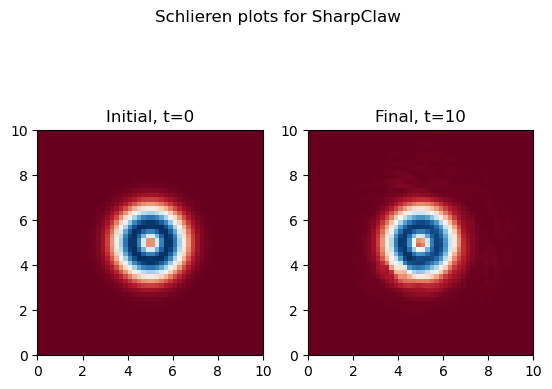

In [25]:
%matplotlib inline

frameSC_init = clawSC.frames[0]
densitySC_init = frameSC_init.q[0,:,:]
(vxSC_init,vySC_init) = np.gradient(densitySC_init)
vsSC_init = np.sqrt(vxSC_init**2 + vySC_init**2)
x, y = frameSC_init.state.grid.c_centers 
frameSC_fin = clawSC.frames[-1]
densitySC_fin = frameSC_fin.q[0,:,:]
(vxSC_fin,vySC_fin) = np.gradient(densitySC_fin)
vsSC_fin = np.sqrt(vxSC_fin**2 + vySC_fin**2)  

figSC,(axSC1, axSC2) = plt.subplots(1, 2)
figSC.suptitle('Schlieren plots for SharpClaw')
axSC1.pcolormesh(x, y, vsSC_init, cmap='RdBu')
axSC1.set_aspect('equal')
axSC1.set_title('Initial, t=0')
axSC2.pcolormesh(x, y, vsSC_fin, cmap='RdBu')
axSC2.set_aspect('equal')
axSC2.set_title('Final, t=10')

In [26]:
#np.linalg.norm(densitySC_init-densitySC_fin,ord='fro')
np.linalg.norm((vsSC_init-vsSC_fin).flatten(),ord=1)*(10**2)/(50**2)

0.04410956391135189

Now we compare performance with the standard Clawpack implementation.

In [27]:
#repeat, the only change is in the solution
clawCP = pyclaw.Controller()
clawCP.tfinal = 10.
clawCP.num_output_times =100

clawCP.solver = pyclaw.ClawSolver2D(riemann_solver)
clawCP.solver.all_bcs = pyclaw.BC.periodic

#grid_size = (50,50)
#domain = pyclaw.Domain( (0.,0.), (10.,10.), grid_size)

clawCP.solution = pyclaw.Solution(clawCP.solver.num_eqn,domain)
gam = 1.4
clawCP.solution.problem_data['gamma']  = gam

# Set initial data
q = clawCP.solution.q
xx,yy = domain.grid.p_centers
eps=5 #vortex strength
xbar=xx-5.0
ybar=yy-5.0
r2=xbar**2+ybar**2
A=eps/(2*np.pi)*np.exp(0.5*(1.0-r2))
dT=-(gam-1.)*eps**2/(8*gam*np.pi**2)*np.exp(1-r2)
S_vor=1
T=1+dT
rho  = pow(T / S_vor, 1 / (gam - 1.));
P=rho*T
c_v=1
c_w=1
# l = xx<0.5; r = xx>=0.5; b = yy<0.5; t = yy>=0.5
q[0,...] =rho
q[1,...] = rho*(c_v-A*ybar)
q[2,...] = rho*(c_w+A*xbar)
q[3,...] = 0.5*rho*((c_v-A*ybar)**2+(c_w+A*xbar)**2) + P/(gam-1.)

clawCP.keep_copy = True       # Keep solution data in memory for plotting
clawCP.output_format = None   # Don't write solution data to file
clawCP.solver.dt_initial=1.e99
status = clawCP.run()

2023-12-11 14:18:18,077 INFO CLAW: Solution 0 computed for time t=0.000000
2023-12-11 14:18:18,088 INFO CLAW: Solution 1 computed for time t=0.100000
2023-12-11 14:18:18,092 INFO CLAW: Solution 2 computed for time t=0.200000
2023-12-11 14:18:18,098 INFO CLAW: Solution 3 computed for time t=0.300000
2023-12-11 14:18:18,103 INFO CLAW: Solution 4 computed for time t=0.400000
2023-12-11 14:18:18,107 INFO CLAW: Solution 5 computed for time t=0.500000
2023-12-11 14:18:18,114 INFO CLAW: Solution 6 computed for time t=0.600000
2023-12-11 14:18:18,119 INFO CLAW: Solution 7 computed for time t=0.700000
2023-12-11 14:18:18,123 INFO CLAW: Solution 8 computed for time t=0.800000
2023-12-11 14:18:18,128 INFO CLAW: Solution 9 computed for time t=0.900000
2023-12-11 14:18:18,135 INFO CLAW: Solution 10 computed for time t=1.000000
2023-12-11 14:18:18,139 INFO CLAW: Solution 11 computed for time t=1.100000
2023-12-11 14:18:18,144 INFO CLAW: Solution 12 computed for time t=1.200000
2023-12-11 14:18:18,15

In [28]:
ianimate.ianimate(clawCP)

2023-12-11 14:18:23,897 INFO CLAW: Animation.save using <class 'matplotlib.animation.HTMLWriter'>


Text(0.5, 1.0, 'Final, t=10')

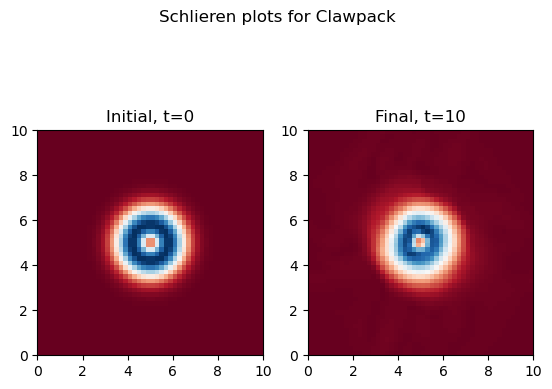

In [29]:
frameCP_init = clawCP.frames[0]
densityCP_init = frameCP_init.q[0,:,:]
(vxCP_init,vyCP_init) = np.gradient(densityCP_init)
vsCP_init = np.sqrt(vxCP_init**2 + vyCP_init**2)
#x, y = frameCP_init.state.grid.c_centers 
frameCP_fin = clawCP.frames[-1]
densityCP_fin = frameCP_fin.q[0,:,:]
(vxCP_fin,vyCP_fin) = np.gradient(densityCP_fin)
vsCP_fin = np.sqrt(vxCP_fin**2 + vyCP_fin**2)  

figCP,(axCP1, axCP2) = plt.subplots(1, 2)
figCP.suptitle('Schlieren plots for Clawpack')
axCP1.pcolormesh(x, y, vsCP_init, cmap='RdBu')
axCP1.set_aspect('equal')
axCP1.set_title('Initial, t=0')
axCP2.pcolormesh(x, y, vsCP_fin, cmap='RdBu')
axCP2.set_aspect('equal')
axCP2.set_title('Final, t=10')

In [30]:
#np.linalg.norm(densityCP_init-densityCP_fin,ord='fro')
np.linalg.norm((vsCP_init-vsCP_fin).flatten(),ord=1)*(10**2)/(50**2)

0.1912222387441664

It is interesting to see the discrepancies between SharpClaw and standard Clawpack results. To investigate it further we perform an error analysis. The error would be a matrix norm of difference between the initial and the final density gradients (can also look at other variables). We will vary the spatial grid size, solve using both methods and report the error.

In [31]:
errSC=[0]*10
for i in range (1,11):
    clawSC = pyclaw.Controller()
    clawSC.tfinal = 10.
    clawSC.num_output_times =100

    clawSC.solver = pyclaw.SharpClawSolver2D(riemann_solver)
    clawSC.solver.all_bcs = pyclaw.BC.periodic

    grid_size = (i*10,i*10)
    domain = pyclaw.Domain( (0.,0.), (10.,10.), grid_size)

    clawSC.solution = pyclaw.Solution(clawSC.solver.num_eqn,domain)
    gam = 1.4
    clawSC.solution.problem_data['gamma']  = gam

# Set initial data
    q = clawSC.solution.q
    xx,yy = domain.grid.p_centers
    eps=5 #vortex strength
    xbar=xx-5.0
    ybar=yy-5.0
    r2=xbar**2+ybar**2
    A=eps/(2*np.pi)*np.exp(0.5*(1.0-r2))
    dT=-(gam-1.)*eps**2/(8*gam*np.pi**2)*np.exp(1-r2)
    S_vor=1
    T=1+dT
    rho  = pow(T / S_vor, 1 / (gam - 1.));
    P=rho*T
    c_v=1
    c_w=1

    q[0,...] =rho
    q[1,...] = rho*(c_v-A*ybar)
    q[2,...] = rho*(c_w+A*xbar)
    q[3,...] = 0.5*rho*((c_v-A*ybar)**2+(c_w+A*xbar)**2) + P/(gam-1.)

    clawSC.keep_copy = True      # Keep solution data in memory for plotting
    clawSC.output_format = None   # Don't write solution data to file
    clawSC.solver.dt_initial=1.e99
    status = clawSC.run()
    frameSC_init = clawSC.frames[0]
    densitySC_init = frameSC_init.q[0,:,:]
    (vxSC_init,vySC_init) = np.gradient(densitySC_init)
    vsSC_init = np.sqrt(vxSC_init**2 + vySC_init**2)
    frameSC_fin = clawSC.frames[-1]
    densitySC_fin = frameSC_fin.q[0,:,:]
    (vxSC_fin,vySC_fin) = np.gradient(densitySC_fin)
    vsSC_fin = np.sqrt(vxSC_fin**2 + vySC_fin**2)  
    errSC[i-1]=np.linalg.norm((vsSC_init-vsSC_fin).flatten(),ord=1)*10**2/(10*i)**2

2023-12-11 14:18:36,754 INFO CLAW: Solution 0 computed for time t=0.000000
2023-12-11 14:18:36,759 INFO CLAW: Solution 1 computed for time t=0.100000
2023-12-11 14:18:36,768 INFO CLAW: Solution 2 computed for time t=0.200000
2023-12-11 14:18:36,771 INFO CLAW: Solution 3 computed for time t=0.300000
2023-12-11 14:18:36,777 INFO CLAW: Solution 4 computed for time t=0.400000
2023-12-11 14:18:36,783 INFO CLAW: Solution 5 computed for time t=0.500000
2023-12-11 14:18:36,787 INFO CLAW: Solution 6 computed for time t=0.600000
2023-12-11 14:18:36,790 INFO CLAW: Solution 7 computed for time t=0.700000
2023-12-11 14:18:36,799 INFO CLAW: Solution 8 computed for time t=0.800000
2023-12-11 14:18:36,802 INFO CLAW: Solution 9 computed for time t=0.900000
2023-12-11 14:18:36,806 INFO CLAW: Solution 10 computed for time t=1.000000
2023-12-11 14:18:36,809 INFO CLAW: Solution 11 computed for time t=1.100000
2023-12-11 14:18:36,817 INFO CLAW: Solution 12 computed for time t=1.200000
2023-12-11 14:18:36,82

In [16]:
errCP=[0]*10
for i in range (1,11):
    clawCP = pyclaw.Controller()
    clawCP.tfinal = 10.
    clawCP.num_output_times =100

    clawCP.solver = pyclaw.ClawSolver2D(riemann_solver)
    clawCP.solver.all_bcs = pyclaw.BC.periodic

    grid_size = (i*10,i*10)
    domain = pyclaw.Domain( (0.,0.), (10.,10.), grid_size)

    clawCP.solution = pyclaw.Solution(clawCP.solver.num_eqn,domain)
    gam = 1.4
    clawCP.solution.problem_data['gamma']  = gam

# Set initial data
    q = clawCP.solution.q
    xx,yy = domain.grid.p_centers
    eps=5 #vortex strength
    xbar=xx-5.0
    ybar=yy-5.0
    r2=xbar**2+ybar**2
    A=eps/(2*np.pi)*np.exp(0.5*(1.0-r2))
    dT=-(gam-1.)*eps**2/(8*gam*np.pi**2)*np.exp(1-r2)
    S_vor=1
    T=1+dT
    rho  = pow(T / S_vor, 1 / (gam - 1.));
    P=rho*T
    c_v=1
    c_w=1

    q[0,...] =rho
    q[1,...] = rho*(c_v-A*ybar)
    q[2,...] = rho*(c_w+A*xbar)
    q[3,...] = 0.5*rho*((c_v-A*ybar)**2+(c_w+A*xbar)**2) + P/(gam-1.)

    clawCP.keep_copy = True      # Keep solution data in memory for plotting
    clawCP.output_format = None   # Don't write solution data to file
    clawCP.solver.dt_initial=1.e99
    status = clawCP.run()
    frameCP_init = clawCP.frames[0]
    densityCP_init = frameCP_init.q[0,:,:]
    (vxCP_init,vyCP_init) = np.gradient(densityCP_init)
    vsCP_init = np.sqrt(vxCP_init**2 + vyCP_init**2)
    frameCP_fin = clawCP.frames[-1]
    densityCP_fin = frameCP_fin.q[0,:,:]
    (vxCP_fin,vyCP_fin) = np.gradient(densityCP_fin)
    vsCP_fin = np.sqrt(vxCP_fin**2 + vyCP_fin**2)  
    errCP[i-1]=np.linalg.norm((vsCP_init-vsCP_fin).flatten(),ord=1)*(10**2)/(10*i)**2

2023-12-11 14:04:44,504 INFO CLAW: Solution 0 computed for time t=0.000000
2023-12-11 14:04:44,507 INFO CLAW: Solution 1 computed for time t=0.100000
2023-12-11 14:04:44,513 INFO CLAW: Solution 2 computed for time t=0.200000
2023-12-11 14:04:44,517 INFO CLAW: Solution 3 computed for time t=0.300000
2023-12-11 14:04:44,521 INFO CLAW: Solution 4 computed for time t=0.400000
2023-12-11 14:04:44,527 INFO CLAW: Solution 5 computed for time t=0.500000
2023-12-11 14:04:44,534 INFO CLAW: Solution 6 computed for time t=0.600000
2023-12-11 14:04:44,538 INFO CLAW: Solution 7 computed for time t=0.700000
2023-12-11 14:04:44,543 INFO CLAW: Solution 8 computed for time t=0.800000
2023-12-11 14:04:44,547 INFO CLAW: Solution 9 computed for time t=0.900000
2023-12-11 14:04:44,551 INFO CLAW: Solution 10 computed for time t=1.000000
2023-12-11 14:04:44,556 INFO CLAW: Solution 11 computed for time t=1.100000
2023-12-11 14:04:44,560 INFO CLAW: Solution 12 computed for time t=1.200000
2023-12-11 14:04:44,56

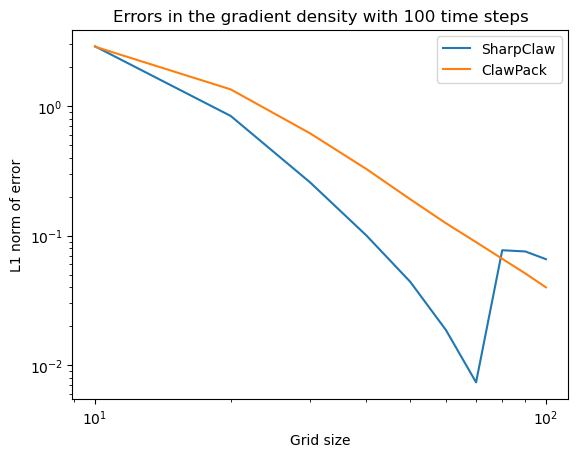

In [32]:
ns=range(10,101,10)
plt.plot(ns,errSC,label=('SharpClaw'))
plt.plot(ns,errCP,label=('ClawPack'))
plt.yscale('log')
plt.xscale('log')
plt.title('Errors in the gradient density with 100 time steps')
plt.xlabel('Grid size')
plt.ylabel('L1 norm of error')
plt.legend()

Interestingly, we can observe that the Sharpclaw might be less accurate than standard Clawpack for bigger grid sizes. We suspect that that passing through the boundaries may play a role, so we repeat the error analysis, but for mean velocities $(0,0)$.

In [33]:
errSC_noBC=[0]*10
for i in range (1,11):
    clawSC = pyclaw.Controller()
    clawSC.tfinal = 10.
    clawSC.num_output_times =100

    clawSC.solver = pyclaw.SharpClawSolver2D(riemann_solver)
    clawSC.solver.all_bcs = pyclaw.BC.periodic

    grid_size = (i*10,i*10)
    domain = pyclaw.Domain( (0.,0.), (10.,10.), grid_size)

    clawSC.solution = pyclaw.Solution(clawSC.solver.num_eqn,domain)
    gam = 1.4
    clawSC.solution.problem_data['gamma']  = gam

# Set initial data
    q = clawSC.solution.q
    xx,yy = domain.grid.p_centers
    eps=5 #vortex strength
    xbar=xx-5.0
    ybar=yy-5.0
    r2=xbar**2+ybar**2
    A=eps/(2*np.pi)*np.exp(0.5*(1.0-r2))
    dT=-(gam-1.)*eps**2/(8*gam*np.pi**2)*np.exp(1-r2)
    S_vor=1
    T=1+dT
    rho  = pow(T / S_vor, 1 / (gam - 1.));
    P=rho*T
    c_v=0
    c_w=0

    q[0,...] =rho
    q[1,...] = rho*(c_v-A*ybar)
    q[2,...] = rho*(c_w+A*xbar)
    q[3,...] = 0.5*rho*((c_v-A*ybar)**2+(c_w+A*xbar)**2) + P/(gam-1.)

    clawSC.keep_copy = True      # Keep solution data in memory for plotting
    clawSC.output_format = None   # Don't write solution data to file
    clawSC.solver.dt_initial=1.e99
    status = clawSC.run()
    frameSC_init = clawSC.frames[0]
    densitySC_init = frameSC_init.q[0,:,:]
    (vxSC_init,vySC_init) = np.gradient(densitySC_init)
    vsSC_init = np.sqrt(vxSC_init**2 + vySC_init**2)
    frameSC_fin = clawSC.frames[-1]
    densitySC_fin = frameSC_fin.q[0,:,:]
    (vxSC_fin,vySC_fin) = np.gradient(densitySC_fin)
    vsSC_fin = np.sqrt(vxSC_fin**2 + vySC_fin**2)  
    errSC_noBC[i-1]=np.linalg.norm((vsSC_init-vsSC_fin).flatten(),ord=1)*(10**2)/(i*10)**2

errCP_noBC=[0]*10
for i in range (1,11):
    clawCP = pyclaw.Controller()
    clawCP.tfinal = 10.
    clawCP.num_output_times =100

    clawCP.solver = pyclaw.ClawSolver2D(riemann_solver)
    clawCP.solver.all_bcs = pyclaw.BC.periodic

    grid_size = (i*10,i*10)
    domain = pyclaw.Domain( (0.,0.), (10.,10.), grid_size)

    clawCP.solution = pyclaw.Solution(clawCP.solver.num_eqn,domain)
    gam = 1.4
    clawCP.solution.problem_data['gamma']  = gam

# Set initial data
    q = clawCP.solution.q
    xx,yy = domain.grid.p_centers
    eps=5 #vortex strength
    xbar=xx-5.0
    ybar=yy-5.0
    r2=xbar**2+ybar**2
    A=eps/(2*np.pi)*np.exp(0.5*(1.0-r2))
    dT=-(gam-1.)*eps**2/(8*gam*np.pi**2)*np.exp(1-r2)
    S_vor=1
    T=1+dT
    rho  = pow(T / S_vor, 1 / (gam - 1.));
    P=rho*T
    c_v=0
    c_w=0

    q[0,...] =rho
    q[1,...] = rho*(c_v-A*ybar)
    q[2,...] = rho*(c_w+A*xbar)
    q[3,...] = 0.5*rho*((c_v-A*ybar)**2+(c_w+A*xbar)**2) + P/(gam-1.)

    clawCP.keep_copy = True      # Keep solution data in memory for plotting
    clawCP.output_format = None   # Don't write solution data to file
    clawCP.solver.dt_initial=1.e99
    status = clawCP.run()
    frameCP_init = clawCP.frames[0]
    densityCP_init = frameCP_init.q[0,:,:]
    (vxCP_init,vyCP_init) = np.gradient(densityCP_init)
    vsCP_init = np.sqrt(vxCP_init**2 + vyCP_init**2)
    frameCP_fin = clawCP.frames[-1]
    densityCP_fin = frameCP_fin.q[0,:,:]
    (vxCP_fin,vyCP_fin) = np.gradient(densityCP_fin)
    vsCP_fin = np.sqrt(vxCP_fin**2 + vyCP_fin**2)  
    errCP_noBC[i-1]=np.linalg.norm((vsCP_init-vsCP_fin).flatten(),ord=1)*(10**2)/(10*i)**2



2023-12-11 14:19:43,285 INFO CLAW: Solution 0 computed for time t=0.000000
2023-12-11 14:19:43,291 INFO CLAW: Solution 1 computed for time t=0.100000
2023-12-11 14:19:43,296 INFO CLAW: Solution 2 computed for time t=0.200000
2023-12-11 14:19:43,300 INFO CLAW: Solution 3 computed for time t=0.300000
2023-12-11 14:19:43,304 INFO CLAW: Solution 4 computed for time t=0.400000
2023-12-11 14:19:43,311 INFO CLAW: Solution 5 computed for time t=0.500000
2023-12-11 14:19:43,314 INFO CLAW: Solution 6 computed for time t=0.600000
2023-12-11 14:19:43,319 INFO CLAW: Solution 7 computed for time t=0.700000
2023-12-11 14:19:43,326 INFO CLAW: Solution 8 computed for time t=0.800000
2023-12-11 14:19:43,331 INFO CLAW: Solution 9 computed for time t=0.900000
2023-12-11 14:19:43,335 INFO CLAW: Solution 10 computed for time t=1.000000
2023-12-11 14:19:43,342 INFO CLAW: Solution 11 computed for time t=1.100000
2023-12-11 14:19:43,348 INFO CLAW: Solution 12 computed for time t=1.200000
2023-12-11 14:19:43,35

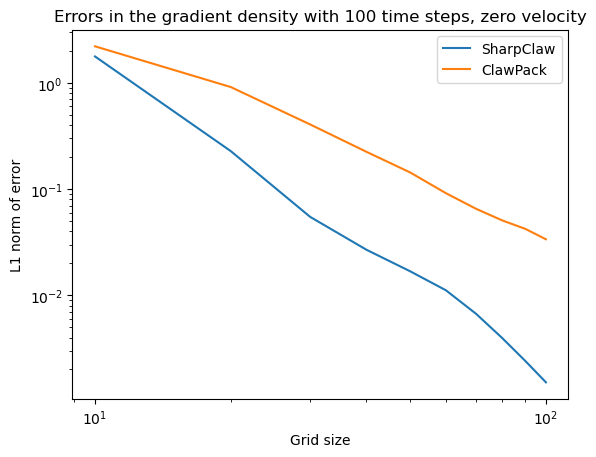

In [34]:
ns=range(10,101,10)
plt.plot(ns,errSC_noBC,label=('SharpClaw'))
plt.plot(ns,errCP_noBC,label=('ClawPack'))
plt.yscale('log')
plt.xscale('log')
plt.title('Errors in the gradient density with 100 time steps, zero velocity')
plt.xlabel('Grid size')
plt.ylabel('L1 norm of error')
plt.legend()

So with zero mean velocities (i.e. the vortex is the center of reference), we see that Sharpclaw is uniformly more accurate that standard Clawpack as expected.